# Importing libraries

In [ ]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Read datasets
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

In [ ]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
#print the shape of the data set
print(df_train.shape)

(16000, 2)


In [ ]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
#print the shape of the data set
print(df_test.shape)

(2000, 2)


In [ ]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [ ]:
#print the shape of the data set
print(df_val.shape)

(2000, 2)


# Assessing

## Train dataset

In [ ]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [ ]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

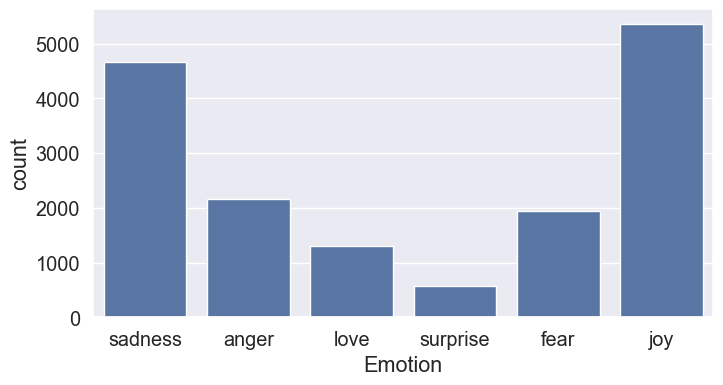

In [98]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [99]:
#print the number of null values in each column
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

The data doesn't contains any null values

In [100]:
#print the number of duplicated values 
df_train.duplicated().sum()

np.int64(1)

There is just one row which is duplicated but we need to check also if there are rows having the same text but different emotions

In [101]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [102]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [103]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
1625,i was intensely conscious of how much cash i h...,anger
7623,i was intensely conscious of how much cash i h...,sadness


In [104]:
df_train[df_train['Text'] == df_train.iloc[14313]['Text']]


,Text,Emotion
13653,i could feel myself hit this strange foggy wall,fear
14313,i could feel myself hit this strange foggy wall,surprise


In [105]:
df_train[df_train['Text'] == df_train.iloc[13879]['Text']]


,Text,Emotion
7333,i feel like i am very passionate about youtube...,joy
13879,i feel like i am very passionate about youtube...,love


In [106]:
#removing duplicated text 
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [107]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

The data contains alot of stopwords (some rows contains more than 25 stopword!) so, we need to take care when we remove them as some rows may become empty 

<Axes: ylabel='Frequency'>

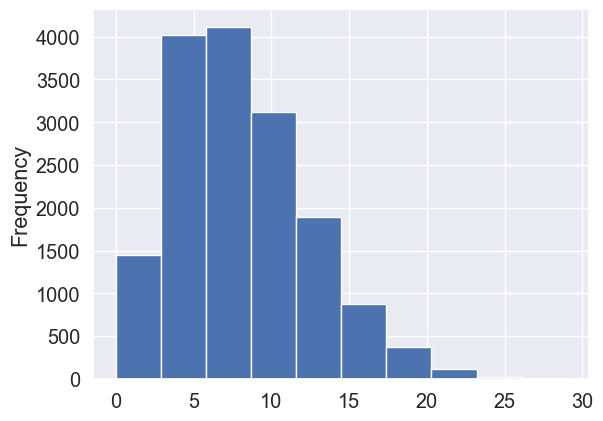

In [108]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')


## Test dataset

In [109]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

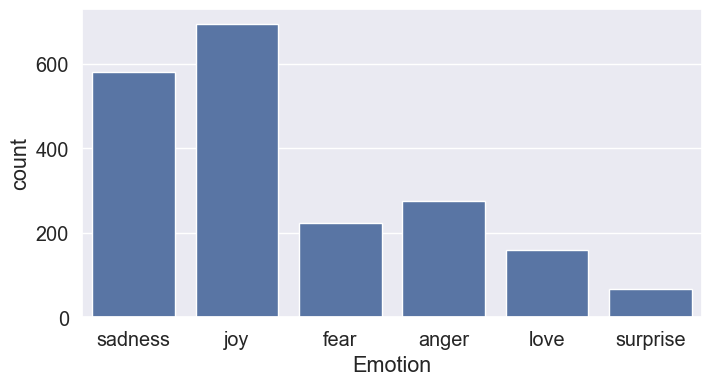

In [110]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);



In [111]:
#print the number of null values in each column
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [112]:
#print the number of duplicated values 
df_test.duplicated().sum()

np.int64(0)

In [113]:

#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]



,Text,Emotion


In [114]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()


stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

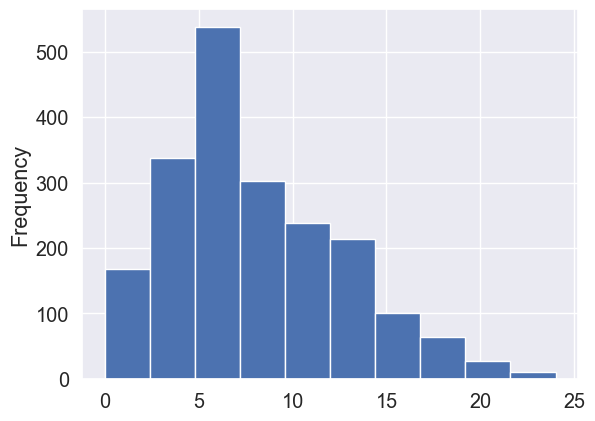

In [115]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

## Validation dataset

In [116]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

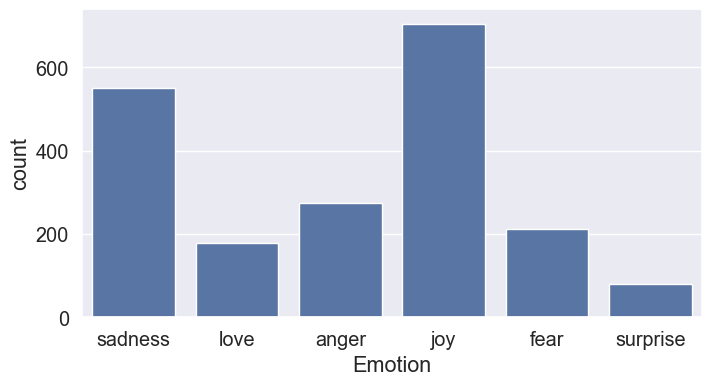

In [117]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [118]:
#print the number of null values in each column
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [119]:
#print the number of duplicated values 
df_val.duplicated().sum()

np.int64(0)

In [120]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [121]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']]


,Text,Emotion
300,i have had several new members tell me how com...,love
603,i have had several new members tell me how com...,joy


In [122]:
df_val[df_val['Text'] == df_val.iloc[1993]['Text']]


,Text,Emotion
774,i feel so tortured by it,fear
1993,i feel so tortured by it,anger


In [123]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [124]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]


stop_words
7     190
5     175
8     173
3     160
6     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

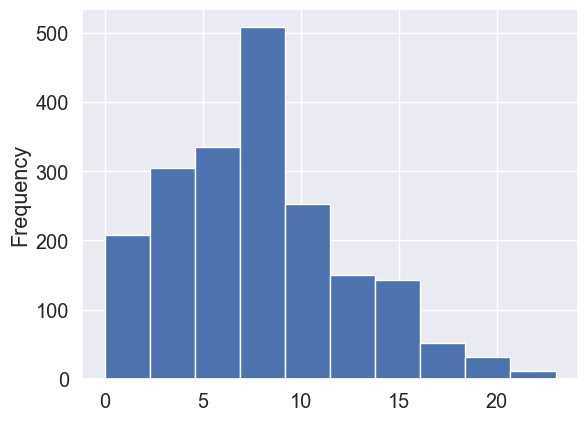

In [125]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

## Compare rows of the datasets

check that there is no data leakage

In [126]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    # Return the filtered DataFrame
    return diff_df

In [127]:
dataframe_difference(df_train, df_test, which='both')

,Text,Emotion,_merge


In [128]:
dataframe_difference(df_train, df_val, which='both')

,Text,Emotion,_merge


In [129]:
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge


## Cleaning

In [130]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

    

<>:29: SyntaxWarning: invalid escape sequence '\]'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\]'
<>:33: SyntaxWarning: invalid escape sequence '\s'
C:\Users\hp\AppData\Local\Temp\ipykernel_18492\3225203475.py:29: SyntaxWarning: invalid escape sequence '\]'
  text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
C:\Users\hp\AppData\Local\Temp\ipykernel_18492\3225203475.py:33: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [131]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")


'name mohamed tweet play egypt'

In [132]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

## Modeling

### TF-IDF
The word counts suffer some issues: most frequent words are usually not important (like stop words), while they take high focus/count.

TFIDF (Term Frequency - Inverse Document) is a way to adjust those counts:

TF: #mentions within a document

IDF: #mentions across all docs 

So it gives higher importance to rare words across all docs (IDF++, TFIDF--), while it emphasyses on words appearing mostly in THIS doc (TF++, TFIDF--).

If a word appearing only in the current doc/sentence, it has TFIDF=1. If a word appears in all docs/sents but not the current one, it has TFIDF=0. If a word (stop word for example) appearing a lot in the current doc/sent and also in ALL others, it will have high TF (count) and much higher IDF (discount), so low TFIDF overall.

We will start by baseline models

**Creating a pipline using tf-idf for words embedding and different models.**


In [133]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [134]:
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.
    
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [135]:
def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

**Training the Logistic Regression model on the Training set**


In [136]:
#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

c:\Users\hp\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [137]:
#Make a single prediction
y_pred=log_reg.predict(['Happy'])
y_pred

array(['joy'], dtype=object)

In [138]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8685 



,F1 score
sadness,0.858223
anger,0.823810
love,0.893048
surprise,0.703704
fear,0.915683
joy,0.626263


In [139]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.89      0.83      0.86       275
        fear       0.88      0.77      0.82       224
         joy       0.83      0.96      0.89       695
        love       0.86      0.60      0.70       159
     sadness       0.90      0.93      0.92       581
    surprise       0.94      0.47      0.63        66

    accuracy                           0.87      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.87      0.87      0.86      2000



**Training the Decision Tree model on the Training set**

In [140]:
#Train the model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.862 



,F1 score
sadness,0.856115
anger,0.815789
love,0.894737
surprise,0.753799
fear,0.903896
joy,0.617647


In [141]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.85      0.87      0.86       275
        fear       0.80      0.83      0.82       224
         joy       0.91      0.88      0.89       695
        love       0.73      0.78      0.75       159
     sadness       0.91      0.90      0.90       581
    surprise       0.60      0.64      0.62        66

    accuracy                           0.86      2000
   macro avg       0.80      0.82      0.81      2000
weighted avg       0.86      0.86      0.86      2000



**Training the Support Vector Machine model on the Training set**


In [ ]:
#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 


In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.86      0.79      0.83       224
         joy       0.83      0.96      0.89       695
        love       0.84      0.57      0.68       159
     sadness       0.91      0.92      0.91       581
    surprise       0.85      0.53      0.65        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.80      2000
weighted avg       0.87      0.87      0.86      2000



**Training the Random Forest model on the Training set**

In [ ]:
#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.8835 



,F1 score
sadness,0.888483
anger,0.869565
love,0.903497
surprise,0.732673
fear,0.929701
joy,0.622951


In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.89      0.88      0.89       275
        fear       0.85      0.89      0.87       224
         joy       0.88      0.93      0.90       695
        love       0.77      0.70      0.73       159
     sadness       0.95      0.91      0.93       581
    surprise       0.68      0.58      0.62        66

    accuracy                           0.88      2000
   macro avg       0.84      0.82      0.82      2000
weighted avg       0.88      0.88      0.88      2000



## Results

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy, DT_accuracy, SVM_accuracy, RF_accuracy]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Random Forest,0.8835
1,Logistic Regression,0.8685
2,Support Vector Machine,0.8675
3,Decision Tree,0.8620


# Lime

LIME, the acronym for local interpretable model-agnostic explanations, is a technique that approximates any black box machine learning model with a local, interpretable model to explain each individual prediction

we need which words contributed the most in the predicition

In [ ]:
#c_LR = make_pipeline(tfidf, clf)
explainer_LR = LimeTextExplainer(class_names=RF.classes_)
idx  = 15
print("Actual Text : ", X_test[idx])
print("Prediction : ", RF.predict(X_test)[idx])
print("Actual :     ", y_test[idx])
exp = explainer_LR.explain_instance(X_test[idx], RF.predict_proba,top_labels=5)
# exp.show_in_notebook()

Actual Text :  feeling heartbroken im sure katniss
Prediction :  sadness
Actual :      sadness


# Better way?
Word embedding using this glove and use a sequance model 

## Text Preprocessing

In [ ]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [ ]:
import re
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm # For progress bars

c:\Users\hp\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
labels = sorted(df_train['Emotion'].unique().tolist())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}
num_labels = len(labels)

In [ ]:

import pandas as pd
import numpy as np
import datasets
import math
from datasets import Dataset, DatasetDict
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import evaluate # Hugging Face's metric library


# --- 3. Convert to Hugging Face Dataset ---
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

ds = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# --- 4. Create Label Mappings ---
# The model needs integer labels


# --- 5. Pre-process and Tokenize Data ---
print("Loading tokenizer and tokenizing data...")
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples['Text'], truncation=True, padding=False) # Padding handled by collator
    # Map string labels to integers
    tokenized_inputs['label'] = [label2id[label] for label in examples['Emotion']]
    return tokenized_inputs

# Apply tokenization to all datasets
tokenized_ds = ds.map(preprocess_function, batched=True)

# Data collator will dynamically pad batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- 6. Define Metrics ---
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# --- 7. Load Model ---
print("Loading pre-trained model for classification...")
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
num_epochs = 3
per_device_batch_size = 16
train_dataset_size = len(tokenized_ds["train"])
steps_per_epoch = math.ceil(train_dataset_size / per_device_batch_size)



Loading tokenizer and tokenizing data...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 4061.62 examples/s]


Loading pre-trained model for classification...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")



Using device: cuda
GPU: NVIDIA GeForce RTX 3050 A Laptop GPU
Available GPU memory: 4.29 GB


In [ ]:


ds = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})



# --- 4. Pre-process and Tokenize Data ---
print("Loading tokenizer and tokenizing data...")
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples['Text'], truncation=True, padding=False)
    tokenized_inputs['label'] = [label2id[label] for label in examples['Emotion']]
    return tokenized_inputs

tokenized_ds = ds.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- 5. Define Metrics ---
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# --- 6. Bagging: Train Multiple Models on Different Seeds ---
model_seeds = [42, 1, 27]  # Train 3 models. You can add more seeds.
all_test_predictions = []
per_device_batch_size = 16
num_epochs = 3

for seed in model_seeds:
    print(f"\n--- Training Model with Seed: {seed} ---")
    
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    
    train_dataset_size = len(tokenized_ds["train"])
    steps_per_epoch = math.ceil(train_dataset_size / per_device_batch_size)

    training_args = TrainingArguments(
    output_dir=f"./emotion-classifier-seed-{seed}",
    learning_rate=2e-5,
    per_device_train_batch_size=per_device_batch_size,
    per_device_eval_batch_size=per_device_batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    seed=seed,  # Set the random seed
    
    # Evaluation and saving strategies
    eval_strategy="steps",        # Required for eval_steps to work
    save_strategy="steps",        # Required for save_steps to work
    logging_strategy="steps",     # Optional but good to include
    
    # Step intervals
    logging_steps=steps_per_epoch,
    eval_steps=steps_per_epoch,
    save_steps=steps_per_epoch,
    
    # Best model selection
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    
    # Hub and reporting
    push_to_hub=False,
    report_to="none"
)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    trainer.train()
    
    # Get test set predictions (logits/probabilities)
    print(f"Generating test predictions for model (Seed: {seed})")
    predictions = trainer.predict(tokenized_ds["test"])
    
    # Add the softmax probabilities to our list
    # We apply softmax to the logits to get probabilities
    softmax_probs = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1).numpy()
    all_test_predictions.append(softmax_probs)

# --- 7. Ensemble Predictions (Soft Voting) ---
print("\n--- Ensembling Predictions ---")
# Stack predictions [model_1_probs, model_2_probs, ...]
prediction_stack = np.stack(all_test_predictions)

# Average the probabilities across all models
mean_probs = np.mean(prediction_stack, axis=0)

# Get the final class prediction
y_pred_labels = np.argmax(mean_probs, axis=1)

# --- 8. Final Evaluation ---
y_true_labels = tokenized_ds["test"]["label"]

# Convert integer labels back to string labels for the report
y_pred_str = [id2label[label] for label in y_pred_labels]
y_true_str = [id2label[label] for label in y_true_labels]

print("Final Bagged Model Accuracy:", accuracy_score(y_true_str, y_pred_str))
print("\nFinal Bagged Model Classification Report:")
print(classification_report(y_true_str, y_pred_str, target_names=labels))

Loading tokenizer and tokenizing data...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 4140.17 examples/s]



--- Training Model with Seed: 42 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_17120\1784542908.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
999,0.467900,0.200893,0.927928
1998,0.146300,0.165982,0.935435
2997,0.098100,0.163485,0.936436


Generating test predictions for model (Seed: 42)



--- Training Model with Seed: 1 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_17120\1784542908.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
999,0.483100,0.202308,0.935435
1998,0.146100,0.173353,0.937437
2997,0.100100,0.164909,0.937938


Generating test predictions for model (Seed: 1)



--- Training Model with Seed: 27 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_17120\1784542908.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
999,0.473200,0.199260,0.927928
1998,0.147200,0.181331,0.939439
2997,0.094000,0.175976,0.934935


Generating test predictions for model (Seed: 27)



--- Ensembling Predictions ---
Final Bagged Model Accuracy: 0.932

Final Bagged Model Classification Report:
              precision    recall  f1-score   support

       anger       0.94      0.93      0.94       275
        fear       0.91      0.90      0.91       224
         joy       0.94      0.95      0.95       695
        love       0.84      0.82      0.83       159
     sadness       0.97      0.97      0.97       581
    surprise       0.73      0.73      0.73        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
import numpy as np
import torch
import math
import evaluate # for evaluate.load("accuracy")
from datasets import DatasetDict # Assuming ds is already defined
from transformers import (
    # --- CHANGED ---
    RobertaTokenizer,
    RobertaForSequenceClassification,
    # ---
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report, accuracy_score

# --- These variables are assumed to be defined from your previous code ---
# ds = DatasetDict(...)
# label2id = {'anger': 0, 'joy': 1, ...}
# id2label = {0: 'anger', 1: 'joy', ...}
# num_labels = len(labels)
# labels = ['anger', 'joy', ...]
# -----------------------------------------------------------------------

In [ ]:
# --- 4. Pre-process and Tokenize Data ---
print("Loading RoBERTa tokenizer and tokenizing data...") # <--- CHANGED text
model_name = 'roberta-base'  # <--- CHANGED
tokenizer = RobertaTokenizer.from_pretrained(model_name) # <--- CHANGED

def preprocess_function(examples):
    # This function remains the same
    tokenized_inputs = tokenizer(examples['Text'], truncation=True, padding=False)
    tokenized_inputs['label'] = [label2id[label] for label in examples['Emotion']]
    return tokenized_inputs

tokenized_ds = ds.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- 5. Define Metrics ---
# This section remains the same
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# --- 6. Bagging: Train Multiple Models on Different Seeds ---
model_seeds = [42, 1, 27]  # Train 3 models. You can add more seeds.
all_test_predictions = []
per_device_batch_size = 16 # RoBERTa is larger, you may need to DECREASE this (e.g., to 8)
num_epochs = 3

for seed in model_seeds:
    print(f"\n--- Training RoBERTa Model with Seed: {seed} ---") # <--- CHANGED text
    
    # --- CHANGED MODEL CLASS ---
    model = RobertaForSequenceClassification.from_pretrained(
        model_name, # This is now 'roberta-base'
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    
    train_dataset_size = len(tokenized_ds["train"])
    steps_per_epoch = math.ceil(train_dataset_size / per_device_batch_size)

    training_args = TrainingArguments(
        output_dir=f"./emotion-classifier-roberta-seed-{seed}", # <--- CHANGED
        learning_rate=2e-5,
        per_device_train_batch_size=per_device_batch_size,
        per_device_eval_batch_size=per_device_batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        seed=seed,  # Set the random seed
        
        # Evaluation and saving strategies
        eval_strategy="steps",
        save_strategy="steps",
        logging_strategy="steps",
        
        # Step intervals
        logging_steps=steps_per_epoch,
        eval_steps=steps_per_epoch,
        save_steps=steps_per_epoch,
        
        # Best model selection
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        
        # Hub and reporting
        push_to_hub=False,
        report_to="none"
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    trainer.train()
    
    # Get test set predictions (logits/probabilities)
    print(f"Generating test predictions for RoBERTa model (Seed: {seed})")
    predictions = trainer.predict(tokenized_ds["test"])
    
    # Add the softmax probabilities to our list
    softmax_probs = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1).numpy()
    all_test_predictions.append(softmax_probs)

# --- 7. Ensemble Predictions (Soft Voting) ---
# This section remains the same
print("\n--- Ensembling Predictions ---")
prediction_stack = np.stack(all_test_predictions)
mean_probs = np.mean(prediction_stack, axis=0)
y_pred_labels = np.argmax(mean_probs, axis=1)

# --- 8. Final Evaluation ---
# This section remains the same
y_true_labels = tokenized_ds["test"]["label"]

y_pred_str = [id2label[label] for label in y_pred_labels]
y_true_str = [id2label[label] for label in y_true_labels]

print("Final Bagged RoBERTa Model Accuracy:", accuracy_score(y_true_str, y_pred_str))
print("\nFinal Bagged RoBERTa Model Classification Report:")
print(classification_report(y_true_str, y_pred_str, target_names=labels))

Loading RoBERTa tokenizer and tokenizing data...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 4810.15 examples/s]



--- Training RoBERTa Model with Seed: 42 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_18492\689767920.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
999,0.492500,0.244502,0.924424
1998,0.181500,0.171944,0.938939
2997,0.121300,0.146172,0.937938


Generating test predictions for RoBERTa model (Seed: 42)



--- Training RoBERTa Model with Seed: 1 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_18492\689767920.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
999,0.522200,0.223471,0.925926
1998,0.174700,0.179910,0.931431
2997,0.119300,0.141749,0.936937


Generating test predictions for RoBERTa model (Seed: 1)



--- Training RoBERTa Model with Seed: 27 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_18492\689767920.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
999,0.495100,0.212316,0.920921
1998,0.183400,0.174662,0.943443
2997,0.120500,0.146454,0.938438


Generating test predictions for RoBERTa model (Seed: 27)



--- Ensembling Predictions ---
Final Bagged RoBERTa Model Accuracy: 0.9295

Final Bagged RoBERTa Model Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.92      0.93       275
        fear       0.88      0.94      0.91       224
         joy       0.93      0.97      0.95       695
        love       0.91      0.75      0.82       159
     sadness       0.96      0.97      0.96       581
    surprise       0.97      0.55      0.70        66

    accuracy                           0.93      2000
   macro avg       0.93      0.85      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical



VOCAB_SIZE = 10000  # Max number of words in the vocabulary
MAX_LEN = 120       # Max length of sequences (tweets/sentences)
OOV_TOKEN = "<OOV>" # Token for words not in the vocabulary

# Initialize and fit the tokenizer on the training text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure they all have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Shape of X_train_pad: {X_train_pad.shape}")

# --- 3. Label Preprocessing ---

# Convert string labels to integer IDs
y_train_ids = np.array([label2id[label] for label in y_train])
y_val_ids = np.array([label2id[label] for label in y_val])
y_test_ids = np.array([label2id[label] for label in y_test])

# One-hot encode the integer labels
y_train_cat = to_categorical(y_train_ids, num_classes=num_labels)
y_val_cat = to_categorical(y_val_ids, num_classes=num_labels)
y_test_cat = to_categorical(y_test_ids, num_classes=num_labels)

print(f"Shape of y_train_cat: {y_train_cat.shape}")
print("-" * 30)

# --- 4. Build the BiLSTM Model ---

EMBEDDING_DIM = 128  # Dimension for the word embeddings
LSTM_UNITS = 64      # Number of units in the LSTM layer

model = Sequential()

# 1. Embedding Layer
# Input_dim is VOCAB_SIZE, which includes the <OOV> token
model.add(Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_length=MAX_LEN))

# 2. Bidirectional LSTM Layer
# This processes the sequence in both forward and backward directions
model.add(Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=False)))

# 3. Dropout Layer (for regularization)
model.add(Dropout(0.5))

# 4. Output Layer
# Dense layer with softmax activation for multi-class classification
model.add(Dense(units=num_labels, activation='softmax'))

# --- 5. Compile the Model ---

model.compile(
    loss='categorical_crossentropy',  # Use for multi-class, one-hot labels
    optimizer='adam',                 # A good default optimizer
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()
print("-" * 30)

# --- 6. Train the Model ---

EPOCHS = 10
BATCH_SIZE = 32

print("--- Starting Model Training ---")
history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val_cat),
    verbose=2  # Shows one line of output per epoch
)
print("--- Model Training Finished ---")
print("-" * 30)

# --- 7. Evaluate the Model ---

print("--- Evaluating Model on Test Data ---")
results = model.evaluate(X_test_pad, y_test_cat, batch_size=BATCH_SIZE)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print("-" * 30)

# --- 8. Example Prediction ---

print("--- Example Prediction ---")
sample_text = ["I am feeling wonderful and absolutely joyful today"]

# Preprocess the new text
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_pad = pad_sequences(sample_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Get prediction (returns probabilities for each class)
prediction_probs = model.predict(sample_pad)[0]

# Find the class with the highest probability
predicted_id = np.argmax(prediction_probs)
predicted_label = id2label[predicted_id]

print(f"Text: '{sample_text[0]}'")
print(f"Predicted Emotion: {predicted_label} (ID: {predicted_id})")
print(f"Confidence: {prediction_probs[predicted_id]:.4f}")
# print(f"All Probabilities: {prediction_probs}")

Shape of X_train_pad: (15969, 120)
Shape of y_train_cat: (15969, 6)
------------------------------


c:\Users\hp\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

------------------------------
--- Starting Model Training ---
Epoch 1/10
500/500 - 20s - 39ms/step - accuracy: 0.6245 - loss: 1.0117 - val_accuracy: 0.8744 - val_loss: 0.3801
Epoch 2/10
500/500 - 16s - 33ms/step - accuracy: 0.9247 - loss: 0.2327 - val_accuracy: 0.9084 - val_loss: 0.2704
Epoch 3/10
500/500 - 16s - 32ms/step - accuracy: 0.9616 - loss: 0.1135 - val_accuracy: 0.9129 - val_loss: 0.2967
Epoch 4/10
500/500 - 16s - 32ms/step - accuracy: 0.9743 - loss: 0.0783 - val_accuracy: 0.9054 - val_loss: 0.3340
Epoch 5/10
500/500 - 17s - 33ms/step - accuracy: 0.9804 - loss: 0.0600 - val_accuracy: 0.9094 - val_loss: 0.3298
Epoch 6/10
500/500 - 16s - 32ms/step - accuracy: 0.9850 - loss: 0.0450 - val_accuracy: 0.9084 - val_loss: 0.3792
Epoch 7/10
500/500 - 18s - 36ms/step - accuracy: 0.9869 - loss: 0.0349 - val_accuracy: 0.9069 - val_loss: 0.4191
Epoch 8/10
500/500 - 18s - 36ms/step - accuracy: 0.9899 - loss: 0.0313 - val_accuracy: 0.9064 - val_loss: 0.4186
Epoch 9/10
500/500 - 33s - 66ms/s

In [ ]:
import pickle

In [ ]:
print("--- Saving model and tokenizer ---")

# 1. Save the Keras model
# This saves the architecture, weights, and optimizer state in a single H5 file
MODEL_PATH = 'bilstm_emotion_model.h5'
model.save(MODEL_PATH)
print(f"✓ Model saved to {MODEL_PATH}")

# 2. Save the Tokenizer
# The tokenizer must be saved to process new text in the same way
TOKENIZER_PATH = 'keras_tokenizer.pkl'
with open(TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"✓ Tokenizer saved to {TOKENIZER_PATH}")

print("-" * 30)

--- Saving model and tokenizer ---
✓ Model saved to bilstm_emotion_model.h5
✓ Tokenizer saved to keras_tokenizer.pkl
------------------------------


In [ ]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import torch
# ============================================================
# CONFIGURATION
# ============================================================
DISTILBERT_MODEL_PATH = 'emotion-classifier-seed-27/checkpoint-1998'
ROBERTA_MODEL_PATH = 'emotion-classifier-roberta-seed-27\checkpoint-1998'
TOKENIZER_PATH = 'keras_tokenizer.pkl'  # Path to your BiLSTM tokenizer
MAX_LEN = 100  # Max sequence length used in BiLSTM training
# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ============================================================
# 1. LOAD MODELS
# ============================================================
print("Loading models...")

# Load DistilBERT model
print("  - Loading DistilBERT...")
distilbert_model = DistilBertForSequenceClassification.from_pretrained(DISTILBERT_MODEL_PATH,local_files_only=True)
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(DISTILBERT_MODEL_PATH)
distilbert_model.to(device)  # Move to GPU
distilbert_model.eval()  # Set to evaluation mode

# Load RoBERTa model
print("  - Loading RoBERTa...")
roberta_model = RobertaForSequenceClassification.from_pretrained(ROBERTA_MODEL_PATH)
roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_PATH)  # not 'roberta-base'
roberta_model.to(device)  # Move to GPU
roberta_model.eval()  # Set to evaluation mode

# Load BiLSTM model


print("✓ All models loaded successfully!")



print(f"\nLabels: {label2id}")
print(f"Number of classes: {num_labels}")


def get_distilbert_predictions(texts, batch_size=32, max_length=512):
    """Return softmax probabilities from fine-tuned DistilBERT in correct label order."""
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch = distilbert_tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = distilbert_model(**batch)
        probs = torch.softmax(outputs.logits, dim=-1)
        # probs = probs[:, class_ids_in_order]  # keep label order consistent
        # all_probs.append(probs.cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())

    return np.vstack(all_probs)


def get_roberta_predictions(texts, batch_size=32, max_length=512):
    """Return probabilities in the model's class order (0..num_labels-1)."""
    all_probs = []
    # 3) Tokenize per batch, not once up-front (saves memory & is safer).
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch = roberta_tokenizer(
            batch_texts,
            truncation=True,
            padding=True,          # pad within the batch only
            max_length=max_length,
            return_tensors='pt'
        )
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = roberta_model(**batch)
        probs = torch.softmax(outputs.logits, dim=-1)
        # reorder columns explicitly (paranoia in case of any mismatch)
        # probs = probs[:, class_ids_in_order]
        # all_probs.append(probs.cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
    return np.vstack(all_probs)


<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
C:\Users\hp\AppData\Local\Temp\ipykernel_18492\1513149279.py:24: SyntaxWarning: invalid escape sequence '\c'
  ROBERTA_MODEL_PATH = 'emotion-classifier-roberta-seed-27\checkpoint-1998'



Using device: cuda
GPU: NVIDIA GeForce RTX 3050 A Laptop GPU
Available GPU memory: 4.29 GB
Loading models...
  - Loading DistilBERT...
  - Loading RoBERTa...
✓ All models loaded successfully!

Labels: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}
Number of classes: 6


In [ ]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import torch
# ============================================================
# CONFIGURATION
# ============================================================
DISTILBERT_MODEL_PATH = 'emotion-classifier-seed-27/checkpoint-1998'
ROBERTA_MODEL_PATH = 'emotion-classifier-results-roberta/checkpoint-1998'

# --- BiLSTM Paths ---
# !! IMPORTANT: Update this path to your saved Keras model file (.h5 or directory) !!
BILSTM_MODEL_PATH = 'bilstm_emotion_model.h5' # <--- NEW (Please update this)
TOKENIZER_PATH = 'keras_tokenizer.pkl'      # Path to your BiLSTM tokenizer
MAX_LEN = 120                               # Max sequence length used in BiLSTM training

# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
# Note: TensorFlow (for BiLSTM) will find and use the GPU automatically if available.

# ============================================================
# 1. LOAD MODELS
# ============================================================
print("Loading models...")

# Load DistilBERT model
print("  - Loading DistilBERT...")
distilbert_model = DistilBertForSequenceClassification.from_pretrained(DISTILBERT_MODEL_PATH,local_files_only=True)
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(DISTILBERT_MODEL_PATH)
distilbert_model.to(device)  # Move to GPU
distilbert_model.eval()  # Set to evaluation mode

# Load RoBERTa model
print("  - Loading RoBERTa...")
roberta_model = RobertaForSequenceClassification.from_pretrained(ROBERTA_MODEL_PATH)
roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_PATH)  # not 'roberta-base'
roberta_model.to(device)  # Move to GPU
roberta_model.eval()  # Set to evaluation mode

# Load BiLSTM model
print(f"  - Loading BiLSTM Tokenizer ({TOKENIZER_PATH})...") # <--- NEW
with open(TOKENIZER_PATH, 'rb') as handle:                  # <--- NEW
    bilstm_tokenizer = pickle.load(handle)                  # <--- NEW

print(f"  - Loading BiLSTM Model ({BILSTM_MODEL_PATH})...")  # <--- NEW
bilstm_model = load_model(BILSTM_MODEL_PATH)                # <--- NEW
# You can uncomment this to verify the model structure
# bilstm_model.summary()                                    # <--- NEW (Optional)

print("✓ All models loaded successfully!")

# =Examples of your labels (assuming they are defined from the previous script)
# label2id = {'anger': 0, 'joy': 1, 'love': 2, 'sadness': 3, 'surprise': 4}
# num_labels = len(label2id)
# print(f"\nLabels: {label2id}")
# print(f"Number of classes: {num_labels}")

def get_distilbert_predictions(texts, batch_size=32, max_length=512):
    """Return softmax probabilities from fine-tuned DistilBERT in correct label order."""
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # --- FIX: Ensure all items are strings ---
        batch_texts = [str(text) for text in batch_texts]
        # ----------------------------------------
        
        batch = distilbert_tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.no_grad(): 
            outputs = distilbert_model(**batch)
            
        probs = torch.softmax(outputs.logits, dim=-1)
        all_probs.append(probs.detach().cpu().numpy())

    return np.vstack(all_probs)


def get_roberta_predictions(texts, batch_size=32, max_length=512):
    """Return probabilities in the model's class order (0..num_labels-1)."""
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # --- FIX: Ensure all items are strings ---
        batch_texts = [str(text) for text in batch_texts]
        # ----------------------------------------
        
        batch = roberta_tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = roberta_model(**batch)
            
        probs = torch.softmax(outputs.logits, dim=-1)
        all_probs.append(probs.detach().cpu().numpy())
        
    return np.vstack(all_probs)


def get_bilstm_predictions(texts, batch_size=32):
    """Return softmax probabilities from the Keras BiLSTM model."""
    
    # --- FIX: Ensure all items are strings ---
    # Keras tokenizer also fails on non-string (e.g., float) input
    texts = [str(text) for text in texts]
    # ----------------------------------------
    
    # 1. Tokenize using the loaded Keras tokenizer
    sequences = bilstm_tokenizer.texts_to_sequences(texts)
    
    # 2. Pad sequences using the MAX_LEN from config
    padded_sequences = pad_sequences(
        sequences, 
        maxlen=MAX_LEN,
        padding='post', 
        truncating='post'
    )
    
    # 3. Predict
    probs = bilstm_model.predict(padded_sequences, batch_size=batch_size)
    
    return probs


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 A Laptop GPU
Available GPU memory: 4.29 GB
Loading models...
  - Loading DistilBERT...
  - Loading RoBERTa...


  - Loading BiLSTM Tokenizer (keras_tokenizer.pkl)...
  - Loading BiLSTM Model (bilstm_emotion_model.h5)...
✓ All models loaded successfully!


In [ ]:
bilstm_test_preds = np.argmax(test_probs_bilstm, axis=1)
bilstm_acc = accuracy_score(y_stack_test, bilstm_test_preds)
print(f"BiLSTM Test Accuracy:     {bilstm_acc:.4f}")
distilbert_pred = np.argmax(test_probs_distilbert, axis=1)
distilbert_acc = accuracy_score(y_stack_test, distilbert_pred)
print(f"DistilBert Test Accuracy:     {bilstm_acc:.4f}")
robert_pred= np.argmax(test_probs_roberta, axis=1)
robert_acc = accuracy_score(y_stack_test, robert_pred)
print(f"robert Test Accuracy:     {robert_acc:.4f}")

In [ ]:
# ============================================================
# 2. CREATE STACKING FEATURES
# ============================================================
# (Assuming you have X_train, y_train_ids, X_val, y_val_ids, X_test, y_test_ids)
# (And assuming y_..._ids are 0-indexed integers, not one-hot)

print("\n--- Generating Stacking Features ---")

# --- Validation Set (for training the meta-model) ---
print("Processing Validation data...")
val_probs_bilstm = get_bilstm_predictions(X_val)
val_probs_distilbert = get_distilbert_predictions(X_val)
val_probs_roberta = get_roberta_predictions(X_val)

# Concatenate all probabilities horizontally
# This is our new "X_train" for the stacking model
X_stack_train = np.hstack((
    val_probs_bilstm, 
    val_probs_distilbert, 
    val_probs_roberta
))
# The labels are just the original validation labels
y_stack_train = y_val_ids # Use the integer IDs
print(f"Stacking training features shape: {X_stack_train.shape}") # (n_samples, num_labels * 3)

# --- Test Set (for evaluating the meta-model) ---
print("Processing Test data...")
test_probs_bilstm = get_bilstm_predictions(X_test)
test_probs_distilbert = get_distilbert_predictions(X_test)
test_probs_roberta = get_roberta_predictions(X_test)

# This is our new "X_test" for the stacking model
X_stack_test = np.hstack((
    test_probs_bilstm, 
    test_probs_distilbert, 
    test_probs_roberta
))
y_stack_test = y_test_ids # Use the integer IDs
print(f"Stacking test features shape: {X_stack_test.shape}")


# ============================================================
# 3. TRAIN AND EVALUATE META-CLASSIFIER
# ============================================================
print("\n--- Training Stacking Meta-Classifier ---")

# Initialize a simple meta-classifier
meta_model = LogisticRegression(max_iter=1000)

# Train on the validation set predictions
meta_model.fit(X_stack_train, y_stack_train)

print("✓ Meta-model trained!")

# Evaluate on the test set predictions
print("\n--- Evaluating Meta-Classifier on Test Set ---")
y_stack_pred = meta_model.predict(X_stack_test)



print(classification_report(y_stack_test, y_stack_pred))
print(f"Final Stacking Accuracy: {accuracy_score(y_stack_test, y_stack_pred):.4f}")


--- Generating Stacking Features ---
Processing Validation data...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Stacking training features shape: (1998, 18)
Processing Test data...
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Stacking test features shape: (2000, 18)

--- Training Stacking Meta-Classifier ---
✓ Meta-model trained!

--- Evaluating Meta-Classifier on Test Set ---
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       275
           1       0.91      0.91      0.91       224
           2       0.94      0.97      0.95       695
           3       0.87      0.80      0.83       159
           4       0.97      0.97      0.97       581
           5       0.78      0.70      0.74        66

    accuracy                           0.93      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000

Final Stacking Accuracy: 0.9340
